In [55]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [56]:
# Defining pytorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
# Loading .csv Files
news_file = 'nifty_50_companies_news2.csv'
reddit_file = 'comments_Sentiment(20-09-24).csv'

In [58]:
# Load data
nifty_data = pd.read_csv(news_file)
reddit_data = pd.read_csv(reddit_file)

In [59]:
# Processing Reddit Data
reddit_data['Tag'] = reddit_data['Tag'].str.strip('[]').astype(int)
reddit_data['sentiment'] = reddit_data['Tag']

In [60]:
def filter_nvidia_posts(row):
    title = str(row['Post Title']).lower()
    text = str(row['Post Text']).lower()
    if 'nvidia' in title or 'nvda' in title or 'nvidia' in text or 'nvda' in text:
        return True
    else:
        return False

In [61]:
reddit_data = reddit_data[reddit_data.apply(filter_nvidia_posts, axis=1)].copy()
reddit_data['date_only'] = pd.to_datetime(reddit_data['Date']).dt.date

In [62]:
# Using Google News to do a sentiment analysis for movement prediction
# Model used is BERT-Uncased(can also use BloomBergGPT or FinBERT)
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [63]:
# Getting Sentiment Score
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits).item()
    # Convert predicted class to sentiment score (-2 to 2)
    sentiment_score = predicted_class - 2  # Adjusting classes from 0-4 to -2 to 2
    return sentiment_score

In [64]:
# Applying Sentiment analysis on specific stock news
nvidia_news = nifty_data[nifty_data['topic'].str.contains('NVIDIA|NVDA', case=False)].copy()
nvidia_news.loc[:, 'sentiment'] = nvidia_news['headline'].apply(get_sentiment)
nvidia_news.loc[:, 'date_only'] = pd.to_datetime(nvidia_news['time']).dt.date
nvidia_news.loc[:, 'source'] = 'News'

In [65]:
# Preparing specific data from reddit csv
reddit_data = reddit_data[['Date', 'Subreddit', 'Post Title', 'Post Text', 'sentiment', 'date_only']].copy()
reddit_data.rename(columns={
    'Date': 'time',
    'Post Text': 'content'
}, inplace=True)
reddit_data.loc[:, 'source'] = 'Reddit'
reddit_data.loc[:, 'topic'] = 'NVIDIA'

In [66]:

# Combine data
combined_data = pd.concat([nvidia_news, reddit_data], ignore_index=True)

In [67]:
# Fetch stock data
nvidia_stock_data = yf.download('NVDA', start="2022-01-01", end="2024-12-31")
nvidia_stock_data.reset_index(inplace=True)
nvidia_stock_data['date_only'] = pd.to_datetime(nvidia_stock_data['Date']).dt.date

[*********************100%%**********************]  1 of 1 completed


In [68]:
# Calculating stock movement
nvidia_stock_data['Price_Change'] = nvidia_stock_data['Close'].pct_change()

In [69]:
def label_stock_movement(change):
    if change > 0.01:  # 1% increase
        return 1
    elif change < -0.01:  # 1% decrease
        return -1
    else:
        return 0
nvidia_stock_data['movement'] = nvidia_stock_data['Price_Change'].apply(label_stock_movement)


In [70]:
# Merging Data for final summary
merged_data = pd.merge(combined_data, nvidia_stock_data[['date_only', 'Close', 'movement']],
                       on='date_only', how='left')
merged_data['movement'] = merged_data['movement'].ffill()

# Step 9: Feature Engineering
# Group by date to get daily sentiment scores and counts
daily_sentiment = merged_data.groupby('date_only').agg({
    'sentiment': 'mean',
    'headline': 'count'
}).reset_index()
daily_sentiment.rename(columns={'headline': 'post_count'}, inplace=True)

In [71]:
# Merging with stock data
model_data = pd.merge(daily_sentiment, nvidia_stock_data[['date_only', 'movement', 'Close']], on='date_only', how='inner')

# Sort data by date
model_data.sort_values('date_only', inplace=True)

In [72]:

model_data['sentiment_lag1'] = model_data['sentiment'].shift(1)
model_data['sentiment_lag2'] = model_data['sentiment'].shift(2)
model_data['post_count_lag1'] = model_data['post_count'].shift(1)
model_data['post_count_lag2'] = model_data['post_count'].shift(2)

In [73]:
# Drop rows with NaN values
model_data.dropna(inplace=True)

In [74]:
# Features and target
features = model_data[['sentiment', 'sentiment_lag1', 'sentiment_lag2', 'post_count', 'post_count_lag1', 'post_count_lag2']]
target = model_data['movement']

# Encode target labels to 0,1,2 where 0 is neutral, 1 is Positive and 2 is Negative
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target + 1)  # Adjust to make labels 0,1,2

# Check class distribution
print("Class distribution in target:", np.bincount(target_encoded))

Class distribution in target: [23  8 17]


In [75]:
# Splitting Testing and Training Data
X = features.values
y = target_encoded


tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_index, test_index = splits[-1]  # Check for last split
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
dates_train = model_data['date_only'].iloc[train_index]
dates_test = model_data['date_only'].iloc[test_index]

In [76]:
# Imbalance and weighting classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights_dict)

# Using Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)
rf_model.fit(X_train, y_train)

Class weights: {0: 0.7017543859649122, 1: 1.9047619047619047, 2: 0.9523809523809523}


RandomForestClassifier(class_weight={0: 0.7017543859649122,
                                     1: 1.9047619047619047,
                                     2: 0.9523809523809523},
                       random_state=42)

In [77]:
# Evaluation

y_pred = rf_model.predict(X_test)
unique_classes = np.unique(y_test)
print("Unique classes in y_test:", unique_classes)

target_names = label_encoder.inverse_transform(unique_classes) - 1  

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names.astype(str), zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Unique classes in y_test: [0 1 2]
Classification Report:
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40         4
           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3

    accuracy                           0.25         8
   macro avg       0.11      0.17      0.13         8
weighted avg       0.17      0.25      0.20         8

Confusion Matrix:
[[2 0 2]
 [1 0 0]
 [3 0 0]]


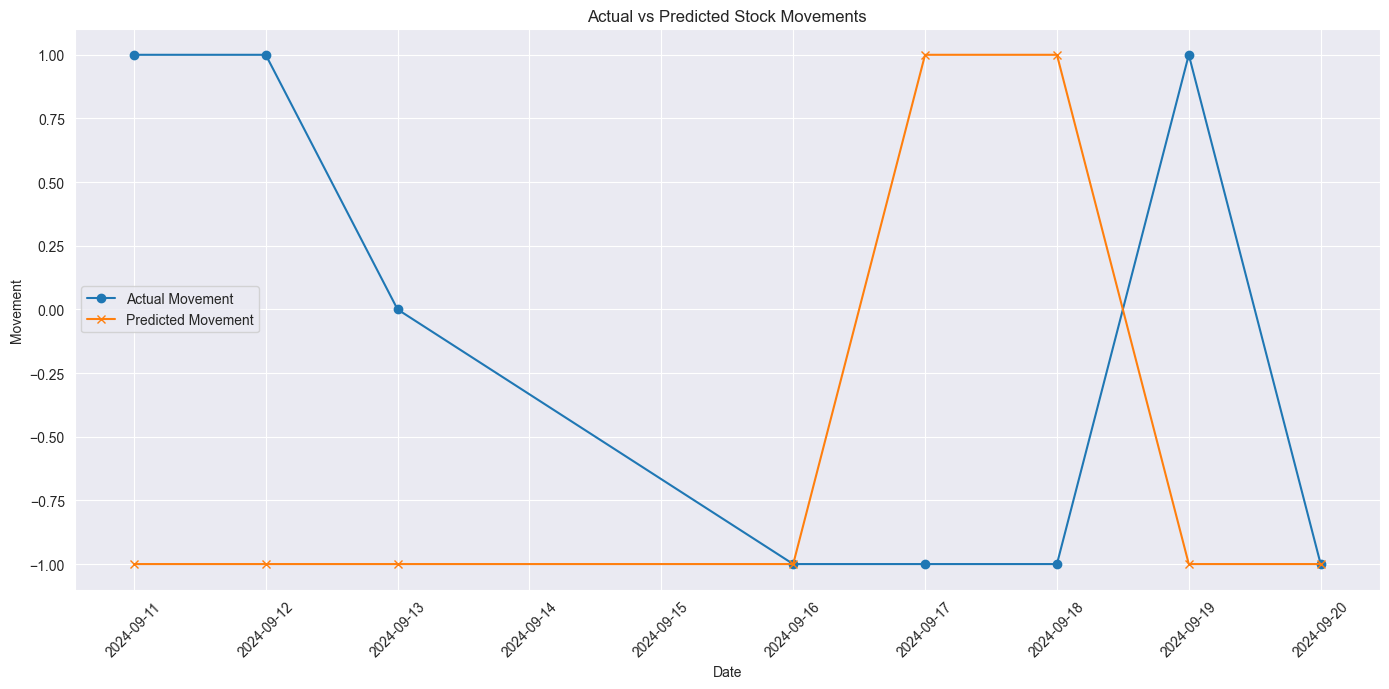

In [78]:
# Visualizations or projections
plt.figure(figsize=(14,7))
plt.plot(dates_test, label_encoder.inverse_transform(y_test) - 1, label='Actual Movement', marker='o')
plt.plot(dates_test, label_encoder.inverse_transform(y_pred) - 1, label='Predicted Movement', marker='x')
plt.title('Actual vs Predicted Stock Movements')
plt.xlabel('Date')
plt.ylabel('Movement')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()